In [37]:
#libraries

#data analysis
import pandas as pd
import numpy as np
import random as rnd

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [38]:
#Load train and test datasets

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

combine = [train_df, test_df]

In [39]:
#Preview data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


There are numerical(Continous: Age, Fare. Discrete: SibSp, Parch), categorical(Categorical: Survived, Sex, and Embarked. Ordinal: Pclass) and mixed type(Ticket and Cabin) features.

In [40]:
# Check for nulls
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [41]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
Cabin > Age are incomplete in case of test dataset.

In [42]:
# Check the distribution of numerical feature values.
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There are some outliers in Age and Fare columns.
Survived is a categorical feature with 0 or 1 values.
Most passengers (> 75%) did not travel with parents or children.

In [43]:
# Check the distribution of categorical feature values.
train_df.describe(include = 'O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Coleridge, Mr. Reginald Charles",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


Names are unique across the dataset (count=unique=891)
Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
Cabin values have several duplicates across samples. Alternatively several passengers shared a cabin.
Embarked takes three possible values. S port used by most passengers (top=S)
Ticket feature has high ratio (22%) of duplicate values (unique=681).

In this step, we need to make assumptions based on the data analysis done so far. We want to know how well does each feature correlate with Survival.

In [44]:
train_df[['Pclass', 'Survived']].groupby('Pclass', as_index = False).mean().sort_values('Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


We observe significant correlation (>0.5) among Pclass=1 and Survived. Including Pclass as feature to our model will be benefical. 

In [45]:
train_df[['Sex', 'Survived']].groupby('Sex', as_index = False).mean().sort_values('Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Sex=female had very high survival rate at 74%

In [46]:
train_df[['SibSp', 'Survived']].groupby('SibSp', as_index = False).mean().sort_values('Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


There is no clear correlation between SibSp and Survived columns.

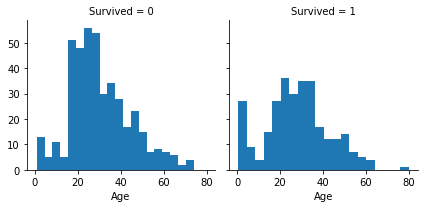

In [47]:
g = sns.FacetGrid(train_df, col = "Survived")
g.map(plt.hist, "Age", bins = 20)

Observations:
Infants (Age <=4) had high survival rate.
Oldest passengers (Age = 80) survived.
Large number of 15-25 year olds did not survive.
Most passengers are in 15-35 age range.

Decisions:
We should consider Age in model training.
Complere Age feature for null values.
We should band age groups.

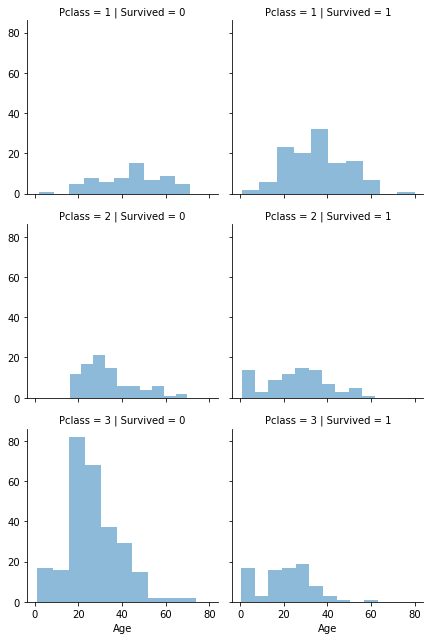

In [48]:
grid = sns.FacetGrid(train_df, col = 'Survived', row = 'Pclass')
grid.map(plt.hist, "Age", alpha = .5)
grid.add_legend()

Observations:
class=3 had most passengers, however most did not survive. 
Infant passengers in Pclass=2 and Pclass=3 mostly survived. 
Most passengers in Pclass=1 survived. 

Decisions:
Consider Pclass as feature for modeling.

C:\Users\msami\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\msami\anaconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


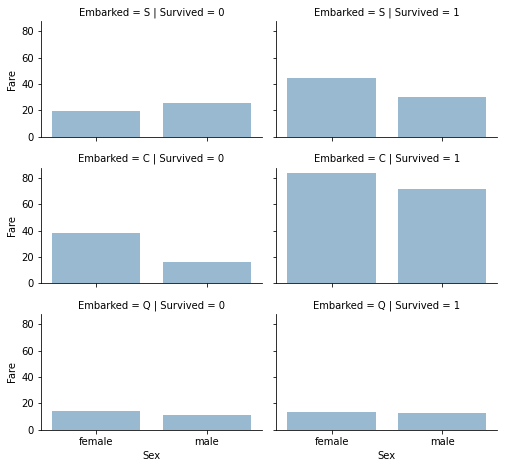

In [49]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

Observations:
Higher fare paying passengers had better survival.
Port of embarkation correlates with survival rates. 

Decisions:
Consider banding Fare feature.

We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating, and completing goals.

In [50]:
#Dropping
train_df = train_df.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis = 1)
test_df = test_df.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis = 1)

In [51]:
combine = [train_df, test_df]

In [52]:
#Converting a categorical feature

for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female' : 1, 'male' : 0}).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S


There are null values in Age column. Before training any model, we have to fill them.

In [53]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [54]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22,1,0,7.2500,S
1,1,1,1,38,1,0,71.2833,C
2,1,3,1,26,0,0,7.9250,S
3,1,1,1,35,1,0,53.1000,S
4,0,3,0,35,0,0,8.0500,S


In [55]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [56]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
0,0,3,0,1,1,0,7.2500,S,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,"(32.0, 48.0]"


In [57]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,1,1,0,7.2500,S
1,1,1,1,2,1,0,71.2833,C
2,1,3,1,1,0,0,7.9250,S
3,1,1,1,2,1,0,53.1000,S
4,0,3,0,2,0,0,8.0500,S


In [58]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [59]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [60]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,1,1,0,7.2500,0
1,1,1,1,2,1,0,71.2833,1
2,1,3,1,1,0,0,7.9250,0
3,1,1,1,2,1,0,53.1000,0
4,0,3,0,2,0,0,8.0500,0


In [61]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,2,0,0,7.8292,2
1,3,1,2,1,0,7.0000,0
2,2,0,3,0,0,9.6875,2
3,3,0,1,0,0,8.6625,0
4,3,1,1,1,1,12.2875,0


In [62]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [63]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,1,1,0,0,0
1,1,1,1,2,1,0,3,1
2,1,3,1,1,0,0,1,0
3,1,1,1,2,1,0,3,0
4,0,3,0,2,0,0,1,0
5,0,3,0,1,0,0,1,2
6,0,1,0,3,0,0,3,0
7,0,3,0,0,3,1,2,0
8,1,3,1,1,0,2,1,0
9,1,2,1,0,1,0,2,1


In [64]:
test_df.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,2,0,0,0,2
1,3,1,2,1,0,0,0
2,2,0,3,0,0,1,2
3,3,0,1,0,0,1,0
4,3,1,1,1,1,1,0
5,3,0,0,0,0,1,0
6,3,1,1,0,0,0,2
7,2,0,1,1,1,2,0
8,3,1,1,0,0,0,1
9,3,0,1,2,0,2,0


In [65]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df

In [66]:
#Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_score = logreg.score(X_train, Y_train) * 100
acc_score

79.57351290684625

In [67]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_score_random_forest = random_forest.score(X_train, Y_train) * 100
acc_score_random_forest

88.66442199775533

In [69]:
models = pd.DataFrame({'Model' : ['LogReg', 'RandomForest'], 'Score': [acc_score, acc_score_random_forest]})
models

,Model,Score
0,LogReg,79.573513
1,RandomForest,88.664422
